In [1]:
import pickle
import numpy as np
import pandas as pd
import chess

In [2]:
with open('2013_01_chess_data.pickle','rb') as read_file:
    chess_df = pickle.load(read_file)

chess_df = chess_df.iloc[0:20000]
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, Game1 to Game20658
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Event            20000 non-null  object
 1   Site             20000 non-null  object
 2   Date             20000 non-null  object
 3   Round            20000 non-null  object
 4   White            20000 non-null  object
 5   Black            20000 non-null  object
 6   Result           20000 non-null  object
 7   BlackElo         20000 non-null  object
 8   BlackRatingDiff  19961 non-null  object
 9   ECO              20000 non-null  object
 10  Opening          20000 non-null  object
 11  Termination      20000 non-null  object
 12  TimeControl      20000 non-null  object
 13  UTCDate          20000 non-null  object
 14  UTCTime          20000 non-null  object
 15  WhiteElo         20000 non-null  object
 16  WhiteRatingDiff  19961 non-null  object
 17  moves            20000 non-n

In [3]:
moves = chess_df['moves']
winner = chess_df['winner']
move_num = chess_df['move_num']
X = []
y = []

In [4]:
max(move_num)

125

In [5]:
char_list = []
for i in range(1,500):
    char_list.append(str(i) + '.')

In [6]:
def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

In [7]:
for game in moves:
    index = list(moves).index(game)
    allmoves = game.split()
    all_moves = [elem for elem in allmoves if elem not in char_list] 
    total_moves = len(all_moves)
    if winner[index] == 'black':
        game_winner = -1
    else:
        game_winner = 1
    board = chess.Board()
    for i in range(len(all_moves)):
        board.push_san(all_moves[i])
        value = game_winner * (i/total_moves)
        matrix = make_matrix(board.copy())
        rows = translate(matrix,chess_dict)
        X.append([rows])
        y.append(value)
X = np.array(X).reshape(len(X),8,8,12)
y = np.array(y)
X.shape

(1287087, 8, 8, 12)

In [8]:
from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=24, kernel_size=1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1,activation = 'tanh'))
model.predict(X)

array([[0.18721922],
       [0.19141077],
       [0.1689485 ],
       ...,
       [0.13711683],
       [0.14276072],
       [0.17361122]], dtype=float32)

Training Network...
Epoch 1/10
40222/40222 - 105s - loss: 0.3279
Epoch 2/10
40222/40222 - 108s - loss: 0.3255
Epoch 3/10
40222/40222 - 112s - loss: 0.3255
Epoch 4/10
40222/40222 - 108s - loss: 0.3252
Epoch 5/10
40222/40222 - 105s - loss: 0.3209
Epoch 6/10
40222/40222 - 107s - loss: 0.3137
Epoch 7/10
40222/40222 - 105s - loss: 0.3107
Epoch 8/10
40222/40222 - 105s - loss: 0.3093
Epoch 9/10
40222/40222 - 105s - loss: 0.3059
Epoch 10/10
40222/40222 - 103s - loss: 0.2903


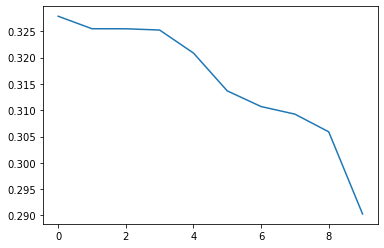

In [17]:
from matplotlib import pyplot as plt
model.compile(optimizer='Nadam', loss='mse')
#dirx = 'C:\\Users\\v_sim\\Desktop\\Files\\Programs\\ML\\Best Models'
#os.chdir(dirx)
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
history = model.fit(X,y,epochs = 10,verbose = 2,callbacks = callback)
plt.plot(history.history['loss'])


Training Network...
Epoch 1/25
40222/40222 - 95s - loss: 0.3272
Epoch 2/25
40222/40222 - 100s - loss: 0.3255
Epoch 3/25
40222/40222 - 103s - loss: 0.3255
Epoch 4/25
40222/40222 - 101s - loss: 0.3255
Epoch 5/25
40222/40222 - 102s - loss: 0.3255
Epoch 6/25
40222/40222 - 102s - loss: 0.3255
Epoch 7/25
40222/40222 - 101s - loss: 0.3255
Epoch 8/25
40222/40222 - 100s - loss: 0.3255
Epoch 9/25
40222/40222 - 100s - loss: 0.3255
Epoch 10/25
40222/40222 - 97s - loss: 0.3255
Epoch 11/25
40222/40222 - 95s - loss: 0.3255
Epoch 12/25
40222/40222 - 97s - loss: 0.3255
Epoch 13/25
40222/40222 - 95s - loss: 0.3255
Epoch 14/25
40222/40222 - 97s - loss: 0.3255
Epoch 15/25
40222/40222 - 96s - loss: 0.3255
Epoch 16/25
40222/40222 - 96s - loss: 0.3255
Epoch 17/25
40222/40222 - 95s - loss: 0.3255
Epoch 18/25
40222/40222 - 94s - loss: 0.3255
Epoch 19/25
40222/40222 - 93s - loss: 0.3255
Epoch 20/25
40222/40222 - 93s - loss: 0.3255
Epoch 21/25
40222/40222 - 94s - loss: 0.3255
Epoch 22/25
40222/40222 - 95s - loss

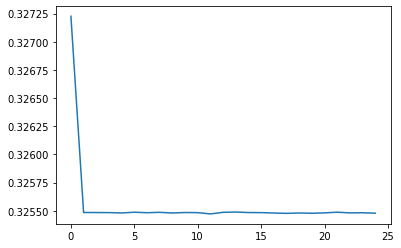

In [10]:
from matplotlib import pyplot as plt
model.compile(optimizer='Nadam', loss='mse')
#dirx = 'C:\\Users\\v_sim\\Desktop\\Files\\Programs\\ML\\Best Models'
#os.chdir(dirx)
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
history = model.fit(X,y,epochs = 25,verbose = 2,callbacks = callback)
plt.plot(history.history['loss'])

In [19]:
randint1 = np.random.randint(1,len(moves))
randint2 = np.random.randint(1,len(all_moves[randint]))
board = chess.Board()
for i in range(randint2):
    board.push_san(all_moves[randint][i])
matrix = make_matrix(board.copy())
rows = translate(matrix,chess_dict)
print('Board Evaluation:',model.predict([rows])[0][0])
board

IndexError: list index out of range

In [ ]:
randint = np.random.randint(1,len(moves))
randint2 = np.random.randint(1,len(moves[randint].split()))
board = chess.Board()
for i in range(randint2):
    board.push_san(moves[randint].split()[i])
matrix = make_matrix(board.copy())
rows = translate(matrix,chess_dict)
print('Board Evaluation:',model.predict([rows])[0][0])
board

In [ ]:
from matplotlib import pyplot as plt
model.compile(optimizer='Nadam', loss='mse')
#dirx = 'C:\\Users\\v_sim\\Desktop\\Files\\Programs\\ML\\Best Models'
#os.chdir(dirx)
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
history = model.fit(X,y,epochs = 10,verbose = 2,callbacks = callback)
plt.plot(history.history['loss'])

Training Network...
Epoch 1/10
40222/40222 - 97s - loss: 0.3276
Epoch 2/10
40222/40222 - 101s - loss: 0.3255
Epoch 3/10
40222/40222 - 102s - loss: 0.3255
Epoch 4/10
40222/40222 - 100s - loss: 0.3255
Epoch 5/10
40222/40222 - 105s - loss: 0.3255
Epoch 6/10
40222/40222 - 107s - loss: 0.3255
Epoch 7/10
40222/40222 - 101s - loss: 0.3255
Epoch 8/10
40222/40222 - 103s - loss: 0.3255
